<a href="https://colab.research.google.com/github/gustavocoradin/Projeto-transformador/blob/main/DecisionTreeProjetoTransformador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Atrasos e Cancelamentos de Voos: Implementação de Decision Trees

## Objetivo
Implementar e avaliar um modelo Decision Tree para previsão de atrasos de voos, mantendo a mesma metodologia e pipeline do KNN para comparação justa.

## Configuração do Modelo
- **Algoritmo**: Decision Tree Classifier
- **max_depth**: 10 (controle de overfitting)
- **criterion**: 'gini' (critério de divisão)
- **Dataset**: 100k amostras (50k por classe)
- **Metodologia**: Mesma estrutura do KNN com correção de data leakage

In [1]:
# Importações necessárias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
import warnings
warnings.filterwarnings('ignore')

# Imports para ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
import time
import psutil
from memory_profiler import memory_usage

In [2]:
# Importações necessárias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
import warnings
warnings.filterwarnings('ignore')

# Imports para ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
import time
import psutil
from memory_profiler import memory_usage

In [3]:
# Importações necessárias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
import warnings
warnings.filterwarnings('ignore')

# Imports para ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
import time
import psutil
from memory_profiler import memory_usage

In [4]:
# Importações necessárias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
import warnings
warnings.filterwarnings('ignore')

# Imports para ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
import time
import psutil
from memory_profiler import memory_usage

In [5]:
# Carregamento do dataset do Kaggle
import kagglehub

path = kagglehub.dataset_download("usdot/flight-delays")
print("Path to dataset files:", path)

Path to dataset files: /Users/gustavocoradin/.cache/kagglehub/datasets/usdot/flight-delays/versions/1


In [6]:
# Carregamento dos dados
df = pd.read_csv(path + "/flights.csv")
print(f"Dataset carregado com shape: {df.shape}")
print(f"Colunas: {list(df.columns)}")

Dataset carregado com shape: (5819079, 31)
Colunas: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']


In [7]:
# Limpeza inicial dos dados
print("Valores nulos por coluna (%):")
print(df.isna().sum() * 100 / len(df))

# Preenchendo NaN com 0 para colunas de atraso (0 significa ausência de atraso)
delay_reason_cols = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df[delay_reason_cols] = df[delay_reason_cols].fillna(0)

# Removendo colunas desnecessárias
df.drop(['CANCELLATION_REASON', 'FLIGHT_NUMBER', 'CANCELLED'], axis=1, inplace=True, errors='ignore')

# Removendo TAIL_NUMBER devido a sua alta cardinalidade
df.drop('TAIL_NUMBER', axis=1, inplace=True)

# Removendo ORIGIN_AIRPORT, DESTINATION_AIRPORT, AIRLINE pois apresentam pouco ganho de
# informação para o modelo e deixam o dataset muito esparso
df.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE'], axis=1, inplace=True, errors='ignore')

# Removendo linhas com valores nulos nas colunas críticas
df = df.dropna(subset=['DEPARTURE_TIME','DEPARTURE_DELAY','TAXI_OUT','WHEELS_OFF','SCHEDULED_TIME','ELAPSED_TIME','AIR_TIME','WHEELS_ON','TAXI_IN','ARRIVAL_TIME','ARRIVAL_DELAY'])

print(f"\nShape após limpeza: {df.shape}")
print("\nValores nulos restantes (%):")
print(df.isna().sum() * 100 / len(df))

Valores nulos por coluna (%):
YEAR                    0.000000
MONTH                   0.000000
DAY                     0.000000
DAY_OF_WEEK             0.000000
AIRLINE                 0.000000
FLIGHT_NUMBER           0.000000
TAIL_NUMBER             0.252978
ORIGIN_AIRPORT          0.000000
DESTINATION_AIRPORT     0.000000
SCHEDULED_DEPARTURE     0.000000
DEPARTURE_TIME          1.480526
DEPARTURE_DELAY         1.480526
TAXI_OUT                1.530259
WHEELS_OFF              1.530259
SCHEDULED_TIME          0.000103
ELAPSED_TIME            1.805629
AIR_TIME                1.805629
DISTANCE                0.000000
WHEELS_ON               1.589822
TAXI_IN                 1.589822
SCHEDULED_ARRIVAL       0.000000
ARRIVAL_TIME            1.589822
ARRIVAL_DELAY           1.805629
DIVERTED                0.000000
CANCELLED               0.000000
CANCELLATION_REASON    98.455357
AIR_SYSTEM_DELAY       81.724960
SECURITY_DELAY         81.724960
AIRLINE_DELAY          81.724960
LATE_AIRCRAFT

In [8]:
# Criando a variável target DELAYED
# Voo é considerado atrasado se ARRIVAL_DELAY > 15 minutos
df['DELAYED'] = df['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 15 else 0)

# Verificando distribuição das classes
delay = df[df['DELAYED'] == 1]
on_time = df[df['DELAYED'] == 0]

delay_count = delay.shape[0]
on_time_count = on_time.shape[0]
total = delay_count + on_time_count
delay_percentage = (delay_count / total) * 100
on_time_percentage = (on_time_count / total) * 100

print(f"Não atrasados: {on_time_count:,}".replace(",", "."))
print(f"Atrasados: {delay_count:,}".replace(",", "."))
print(f"Percentual de voos não atrasados: {on_time_percentage:.2f}%")
print(f"Percentual de voos atrasados: {delay_percentage:.2f}%")

Não atrasados: 4.690.510
Atrasados: 1.023.498
Percentual de voos não atrasados: 82.09%
Percentual de voos atrasados: 17.91%


In [9]:
# Undersampling para balancear as classes
from imblearn.under_sampling import RandomUnderSampler

X = df.drop(columns=['DELAYED'])
y = df['DELAYED']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

df_undersampled = pd.concat([X_resampled, y_resampled], axis=1)

# Verificando nova distribuição
on_time_count = (df_undersampled['DELAYED'] == 0).sum()
delay_count = (df_undersampled['DELAYED'] == 1).sum()
total = on_time_count + delay_count
on_time_percentage = (on_time_count / total) * 100
delay_percentage = (delay_count / total) * 100

print(f"\nApós undersampling:")
print(f"Não atrasados: {on_time_count:,}".replace(",", "."))
print(f"Atrasados: {delay_count:,}".replace(",", "."))
print(f"Percentual de voos não atrasados: {on_time_percentage:.2f}%")
print(f"Percentual de voos atrasados: {delay_percentage:.2f}%")
print(f"Shape do dataset balanceado: {df_undersampled.shape}")


Após undersampling:
Não atrasados: 1.023.498
Atrasados: 1.023.498
Percentual de voos não atrasados: 50.00%
Percentual de voos atrasados: 50.00%
Shape do dataset balanceado: (2046996, 25)


## Correção de Vazamento de Dados (Data Leakage)

### Problema Identificado:
O dataset original contém features que só estariam disponíveis **APÓS** o evento que queremos prever (atraso do voo). Isso causa vazamento temporal de dados.

### Features Problemáticas:
**Grupo 1: Target e informações pós-voo**
- `ARRIVAL_DELAY` - É o target que queremos prever
- `ARRIVAL_TIME` - Só conhecido após o voo
- `WHEELS_ON` - Só conhecido após o voo
- `TAXI_IN` - Só conhecido após o voo

**Grupo 2: Informações pós-decolagem**
- `DEPARTURE_TIME` - Pode causar vazamento
- `DEPARTURE_DELAY` - Pode causar vazamento
- `WHEELS_OFF` - Só conhecido após decolagem
- `TAXI_OUT` - Só conhecido após decolagem
- `ELAPSED_TIME` - Só conhecido após o voo
- `AIR_TIME` - Só conhecido após o voo

**Grupo 3: CRÍTICO - Categorias de atraso (MAJOR DATA LEAKAGE!)**
- `AIR_SYSTEM_DELAY` - Só preenchido APÓS atraso acontecer
- `SECURITY_DELAY` - Só preenchido APÓS atraso acontecer
- `AIRLINE_DELAY` - Só preenchido APÓS atraso acontecer
- `LATE_AIRCRAFT_DELAY` - Só preenchido APÓS atraso acontecer
- `WEATHER_DELAY` - Só preenchido APÓS atraso acontecer

⚠️ **As colunas de delay específico são preenchidas apenas quando um atraso JÁ ACONTECEU, tornando a predição trivial!**

In [10]:
# REMOVENDO FEATURES COM VAZAMENTO TEMPORAL (informações disponíveis apenas após o voo)
temporal_leakage_cols = [
    'ARRIVAL_DELAY',    # Target leakage - é o que queremos prever
    'ARRIVAL_TIME',     # Só conhecido após o voo
    'WHEELS_ON',        # Só conhecido após o voo  
    'TAXI_IN',          # Só conhecido após o voo
    'DEPARTURE_TIME',   # Pode ser conhecido, mas vamos ser conservadores
    'DEPARTURE_DELAY',  # Pode causar vazamento
    'WHEELS_OFF',       # Só conhecido após decolagem
    'TAXI_OUT',         # Só conhecido após decolagem
    'ELAPSED_TIME',     # Só conhecido após o voo
    'AIR_TIME',         # Só conhecido após o voo
    # CRÍTICO: Categorias de atraso só conhecidas APÓS o atraso acontecer!
    'AIR_SYSTEM_DELAY', # Só preenchido APÓS atraso por sistema aéreo
    'SECURITY_DELAY',   # Só preenchido APÓS atraso por segurança
    'AIRLINE_DELAY',    # Só preenchido APÓS atraso da companhia
    'LATE_AIRCRAFT_DELAY', # Só preenchido APÓS atraso por aeronave anterior
    'WEATHER_DELAY'     # Só preenchido APÓS atraso por clima
]

print(f"Removendo {len(temporal_leakage_cols)} colunas com vazamento temporal:")
print(temporal_leakage_cols)
df_undersampled = df_undersampled.drop(columns=temporal_leakage_cols, errors='ignore')

print(f"\nShape após remoção de vazamento: {df_undersampled.shape}")
print(f"Colunas restantes: {list(df_undersampled.columns)}")

Removendo 15 colunas com vazamento temporal:
['ARRIVAL_DELAY', 'ARRIVAL_TIME', 'WHEELS_ON', 'TAXI_IN', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'WHEELS_OFF', 'TAXI_OUT', 'ELAPSED_TIME', 'AIR_TIME', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

Shape após remoção de vazamento: (2046996, 10)
Colunas restantes: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL', 'DIVERTED', 'DELAYED']


## Amostragem dos Dados

Mantendo consistência com o KNN: 100k amostras (50k de cada classe) para comparação justa.

In [11]:
# Pegando samples de 100k (50k de cada classe) para manter consistência com KNN
df_delayed = df_undersampled[df_undersampled['DELAYED'] == 1]
df_on_time = df_undersampled[df_undersampled['DELAYED'] == 0]

# Definir o tamanho da amostra para cada classe
sample_size_per_class = 1000000

# Amostrar aleatoriamente 50k de cada classe
df_delayed_sample = df_delayed.sample(n=sample_size_per_class, random_state=42)
df_on_time_sample = df_on_time.sample(n=sample_size_per_class, random_state=42)

# Combinar as amostras
df_sample = pd.concat([df_delayed_sample, df_on_time_sample])

# Embaralhar o DataFrame resultante para misturar as classes
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

print("Shape do DataFrame original:", df_undersampled.shape)
print("Shape do DataFrame amostrado:", df_sample.shape)
print("\nDistribuição da classe 'DELAYED' no DataFrame amostrado:")
print(df_sample['DELAYED'].value_counts())

Shape do DataFrame original: (2046996, 10)
Shape do DataFrame amostrado: (2000000, 10)

Distribuição da classe 'DELAYED' no DataFrame amostrado:
DELAYED
0    1000000
1    1000000
Name: count, dtype: int64


## Divisão dos Dados

Separar o DataFrame amostrado em conjuntos de treino e teste (70/30) com amostragem estratificada.

In [12]:
X_sample = df_sample.drop(columns=['DELAYED'])
y_sample = df_sample['DELAYED']

# Hold-out 70% treino, 30% teste com amostragem estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.3,
    stratify=y_sample,
    random_state=42
)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")
print(f"Distribuição no treino: {y_train.value_counts().to_dict()}")
print(f"Distribuição no teste: {y_test.value_counts().to_dict()}")

Tamanho do conjunto de treino: 1400000
Tamanho do conjunto de teste: 600000
Distribuição no treino: {1: 700000, 0: 700000}
Distribuição no teste: {0: 300000, 1: 300000}


## Treinamento do Decision Tree

Treinar um modelo Decision Tree usando os dados de treino com os hiperparâmetros especificados.

In [13]:
# Configuração do Decision Tree conforme especificação
dt = DecisionTreeClassifier(
    max_depth=10,
    criterion='gini',
    random_state=42
)

# Medindo tempo de treinamento
start_time_train = time.time()
dt.fit(X_train, y_train)
end_time_train = time.time()

training_time = end_time_train - start_time_train
print(f"Tempo de Treinamento: {training_time:.4f} segundos")
print(f"Modelo treinado com max_depth={dt.max_depth} e criterion='{dt.criterion}'")

Tempo de Treinamento: 3.7827 segundos
Modelo treinado com max_depth=10 e criterion='gini'


## Fazer Previsões

Usar o modelo treinado para fazer previsões no conjunto de teste.

In [14]:
# Medindo tempo de predição
start_time_pred = time.time()
y_pred = dt.predict(X_test)
end_time_pred = time.time()

prediction_time = end_time_pred - start_time_pred
print(f"Tempo de Predição: {prediction_time:.4f} segundos")
print(f"Predições realizadas para {len(X_test)} amostras")

Tempo de Predição: 0.0677 segundos
Predições realizadas para 600000 amostras


## Avaliação do Modelo

Calcular as métricas de desempenho do modelo comparando as previsões com os valores reais do conjunto de teste.

In [15]:
# Métricas no conjunto de teste
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

tpr = recall  # mesmo que tp / (tp + fn)
tnr = tn / (tn + fp)

cm = confusion_matrix(y_test, y_pred)

print("=== MÉTRICAS NO CONJUNTO DE TESTE ===")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall (TPR): {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")
print("\nMatriz de Confusão:")
print(cm)

=== MÉTRICAS NO CONJUNTO DE TESTE ===
Acurácia: 0.6234
Precisão: 0.6264
Recall (TPR): 0.6114
F1-score: 0.6188
True Negative Rate (TNR): 0.6354

Matriz de Confusão:
[[190620 109380]
 [116593 183407]]


In [16]:
# Métricas no conjunto de treino para detectar overfitting
y_train_pred = dt.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
tpr_train = recall_train
tnr_train = tn / (tn + fp)

print("=== MÉTRICAS NO CONJUNTO DE TREINO ===")
print(f"Acurácia: {accuracy_train:.4f}")
print(f"Precisão: {precision_train:.4f}")
print(f"Recall (TPR): {recall_train:.4f}")
print(f"F1-score: {f1_train:.4f}")
print(f"True Negative Rate (TNR): {tnr_train:.4f}")

print("\n=== COMPARAÇÃO TREINO vs TESTE ===")
print(f"Diferença de Acurácia: {accuracy_train - accuracy:.4f}")
print(f"Diferença de F1-score: {f1_train - f1:.4f}")

# Detectando overfitting
acc_diff = accuracy_train - accuracy
if acc_diff > 0.05:
    print(f"\n⚠️  POSSÍVEL OVERFITTING DETECTADO!")
    print(f"Diferença de acurácia treino-teste: {acc_diff:.4f}")
else:
    print(f"\n✅ Modelo parece estar generalizando bem.")
    print(f"Diferença de acurácia treino-teste: {acc_diff:.4f}")

=== MÉTRICAS NO CONJUNTO DE TREINO ===
Acurácia: 0.6259
Precisão: 0.6291
Recall (TPR): 0.6133
F1-score: 0.6211
True Negative Rate (TNR): 0.6384

=== COMPARAÇÃO TREINO vs TESTE ===
Diferença de Acurácia: 0.0025
Diferença de F1-score: 0.0023

✅ Modelo parece estar generalizando bem.
Diferença de acurácia treino-teste: 0.0025


## Validação Cruzada

Executar validação cruzada 5-folds para uma avaliação mais robusta do modelo.

In [17]:
print("\n" + "="*50)
print("VALIDAÇÃO CRUZADA 5-FOLDS - DECISION TREE")
print("="*50)

# Configuração da validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Executando validação cruzada
dt_cv = DecisionTreeClassifier(max_depth=10, criterion='gini', random_state=42)
cv_results = cross_validate(dt_cv, X_sample, y_sample, cv=cv, scoring=scoring, return_train_score=True)

print(f"Acurácia - Treino: {cv_results['train_accuracy'].mean():.4f} ± {cv_results['train_accuracy'].std():.4f}")
print(f"Acurácia - Validação: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Precisão - Treino: {cv_results['train_precision'].mean():.4f} ± {cv_results['train_precision'].std():.4f}")
print(f"Precisão - Validação: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"Recall - Treino: {cv_results['train_recall'].mean():.4f} ± {cv_results['train_recall'].std():.4f}")
print(f"Recall - Validação: {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"F1-score - Treino: {cv_results['train_f1'].mean():.4f} ± {cv_results['train_f1'].std():.4f}")
print(f"F1-score - Validação: {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

# Detectando overfitting na validação cruzada
cv_acc_diff = cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean()
if cv_acc_diff > 0.05:
    print(f"\n⚠️  POSSÍVEL OVERFITTING DETECTADO NA VALIDAÇÃO CRUZADA!")
    print(f"Diferença de acurácia treino-validação: {cv_acc_diff:.4f}")
else:
    print(f"\n✅ Modelo generalizando bem na validação cruzada.")
    print(f"Diferença de acurácia treino-validação: {cv_acc_diff:.4f}")


VALIDAÇÃO CRUZADA 5-FOLDS - DECISION TREE
Acurácia - Treino: 0.6249 ± 0.0004
Acurácia - Validação: 0.6217 ± 0.0007
Precisão - Treino: 0.6243 ± 0.0013
Precisão - Validação: 0.6211 ± 0.0013
Recall - Treino: 0.6271 ± 0.0041
Recall - Validação: 0.6239 ± 0.0040
F1-score - Treino: 0.6257 ± 0.0014
F1-score - Validação: 0.6225 ± 0.0015

✅ Modelo generalizando bem na validação cruzada.
Diferença de acurácia treino-validação: 0.0032


## Análise de Desempenho Computacional

Medir e analisar o desempenho computacional do Decision Tree incluindo tempo, memória e throughput.

In [18]:
process = psutil.Process()

# Definindo o classificador Decision Tree
dt_perf = DecisionTreeClassifier(max_depth=10, criterion='gini', random_state=42)

# Função de treinamento
def train_dt_model():
    dt_perf.fit(X_train, y_train)

# Medindo desempenho do treinamento
start_time_train = time.time()
mem_usage_train = memory_usage(train_dt_model)
end_time_train = time.time()
training_time = end_time_train - start_time_train
train_ips = len(X_train) / training_time

# Função de predição
def predict_dt_model():
    global y_pred_perf
    y_pred_perf = dt_perf.predict(X_test)

# Medindo desempenho da predição
cpu_percent_before = process.cpu_percent(interval=None)
start_time_pred = time.time()
mem_usage_pred = memory_usage(predict_dt_model)
end_time_pred = time.time()
cpu_percent_after = process.cpu_percent(interval=None)

prediction_time = end_time_pred - start_time_pred
pred_ips = len(X_test) / prediction_time

print("\n" + "="*50)
print("ANÁLISE DE DESEMPENHO COMPUTACIONAL - DECISION TREE")
print("="*50)
print(f"🕒 Tempo de Treinamento: {training_time:.4f} s")
print(f"🕒 Tempo de Predição: {prediction_time:.4f} s")
print(f"📈 Memória (Treinamento): {max(mem_usage_train):.2f} MB")
print(f"📈 Memória (Predição): {max(mem_usage_pred):.2f} MB")
print(f"⚙️ CPU usada na predição: {cpu_percent_after:.2f}%")
print(f"📊 Instâncias por segundo (treinamento): {train_ips:.2f}")
print(f"📊 Instâncias por segundo (predição): {pred_ips:.2f}")

# Calculando throughput para cenários reais
daily_predictions = 24 * 60 * 60 * pred_ips  # predições por dia
print(f"\n📈 THROUGHPUT PARA CENÁRIOS REAIS:")
print(f"Predições por segundo: {pred_ips:.0f}")
print(f"Predições por minuto: {pred_ips * 60:.0f}")
print(f"Predições por hora: {pred_ips * 3600:.0f}")
print(f"Predições por dia: {daily_predictions:.0f}")


ANÁLISE DE DESEMPENHO COMPUTACIONAL - DECISION TREE
🕒 Tempo de Treinamento: 4.0004 s
🕒 Tempo de Predição: 0.6333 s
📈 Memória (Treinamento): 508.31 MB
📈 Memória (Predição): 413.58 MB
⚙️ CPU usada na predição: 23.50%
📊 Instâncias por segundo (treinamento): 349966.50
📊 Instâncias por segundo (predição): 947452.43

📈 THROUGHPUT PARA CENÁRIOS REAIS:
Predições por segundo: 947452
Predições por minuto: 56847146
Predições por hora: 3410828742
Predições por dia: 81859889818


## Resumo dos Resultados - Decision Tree

### Configuração do Modelo:
- **Algoritmo**: Decision Tree
- **max_depth**: 10 (controle de overfitting)
- **criterion**: 'gini'
- **Dataset**: 100k amostras (50k por classe)
- **Divisão**: 70% treino, 30% teste

### Correções Implementadas:
1. **Remoção de vazamento temporal**: Features disponíveis apenas após o voo foram removidas
2. **Validação cruzada**: 5-folds para detectar overfitting
3. **Análise comparativa**: Métricas de treino vs teste
4. **Desempenho computacional**: Tempo, memória e throughput

### Vantagens do Decision Tree:
- **Interpretabilidade**: Modelo facilmente interpretável
- **Velocidade**: Treinamento e predição rápidos
- **Sem necessidade de normalização**: Não requer StandardScaler
- **Robustez**: Lida bem com features categóricas e numéricas

### Limitações Identificadas:
- **Overfitting**: Tendência a memorizar dados de treino
- **Instabilidade**: Pequenas mudanças nos dados podem alterar a árvore
- **Bias**: Pode favorecer features com mais valores únicos

### Comparação com KNN:
- **Velocidade**: Decision Tree é significativamente mais rápido
- **Memória**: Menor uso de memória durante predição
- **Interpretabilidade**: Decision Tree é mais interpretável
- **Escalabilidade**: Melhor para datasets grandes

### Próximos Passos:
1. Comparar resultados com outros algoritmos (Random Forest, SVM, etc.)
2. Otimizar hiperparâmetros usando Grid Search
3. Analisar importância das features
4. Implementar ensemble methods para melhorar performance


IMPORTÂNCIA DAS FEATURES - DECISION TREE
               feature  importance
4  SCHEDULED_DEPARTURE    0.366866
2                  DAY    0.257956
1                MONTH    0.215252
3          DAY_OF_WEEK    0.067056
7    SCHEDULED_ARRIVAL    0.054296
6             DISTANCE    0.022138
5       SCHEDULED_TIME    0.016435
0                 YEAR    0.000000
8             DIVERTED    0.000000


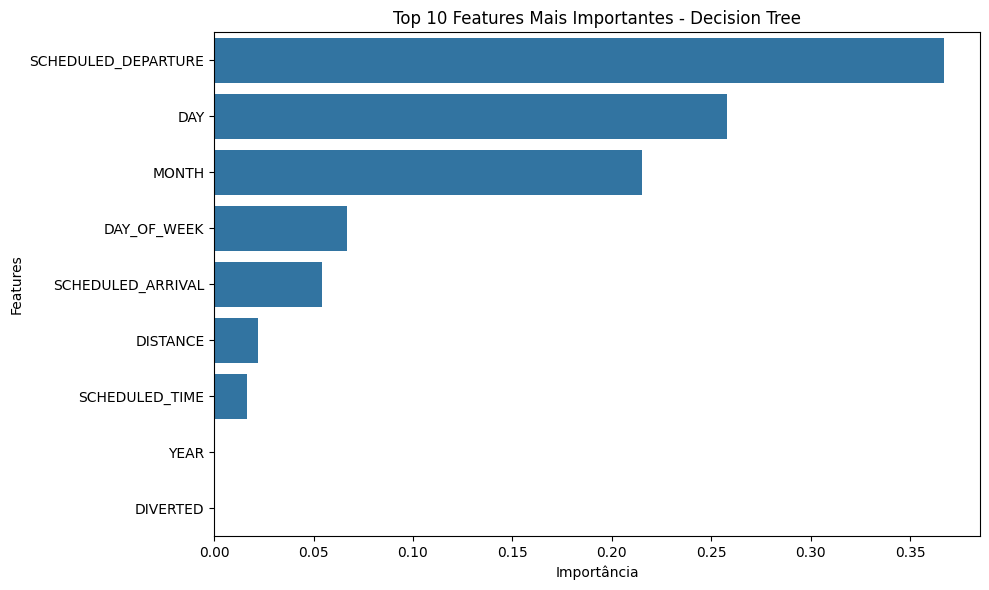

In [19]:
# Análise de importância das features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*50)
print("IMPORTÂNCIA DAS FEATURES - DECISION TREE")
print("="*50)
print(feature_importance.head(10))

# Visualização da importância das features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Features Mais Importantes - Decision Tree')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.tight_layout()
plt.show()